## An introduction to Time series.
### Here is a link to the notebook referred for learning. You can find data from there too.
https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts 

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

In [3]:
## importing time series specific libraries later

In [2]:
!ls data/predictFutureSales/

item_categories.csv   sales_train.csv       shops.csv
items.csv             sample_submission.csv test.csv


In [3]:
## reading data
item_cat = pd.read_csv('data/predictFutureSales/item_categories.csv')
items = pd.read_csv('data/predictFutureSales/items.csv')
sales_train = pd.read_csv('data/predictFutureSales/sales_train.csv')
shops = pd.read_csv('data/predictFutureSales/shops.csv')
test = pd.read_csv('data/predictFutureSales/test.csv')

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales_train['date_block_num'].value_counts().index.sort_values()
## this means that data is of 33 months. This is just a consecutive how many months are there that variable

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
            33],
           dtype='int64')

In [6]:
sales_train.date = sales_train.date.apply(lambda x:datetime.datetime.strptime(x,'%d.%m.%Y'))

In [7]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [8]:
## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

monthly_sales = sales_train.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

/Users/jassification/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


In [9]:
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

In [10]:
ts = sales_train.groupby('date_block_num')['item_cnt_day'].sum()

In [17]:
ts.head()

date_block_num
0    131479.0
1    128090.0
2    147142.0
3    107190.0
4    106970.0
Name: item_cnt_day, dtype: float64

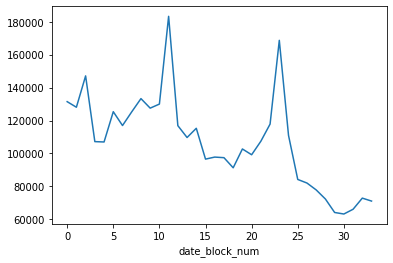

In [11]:
ts.plot()

In [30]:
## you can see that total sales peak around 12 and 24 which is the year end period.
## which might make sense cause of higher sales at year end festivals

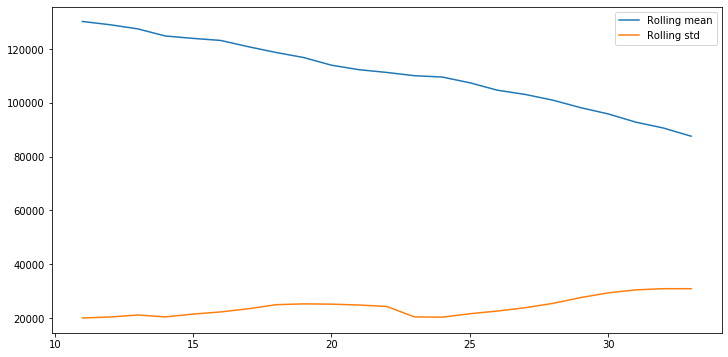

In [12]:
plt.figure(figsize=(12,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling mean')
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling std')
plt.legend()

### Time series can be thought of made of different components like seasonality, trend etc. 
Hence, you need to decompose you TS, statsmodel library provides a good function for this.

/Users/jassification/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 1152x864 with 0 Axes>

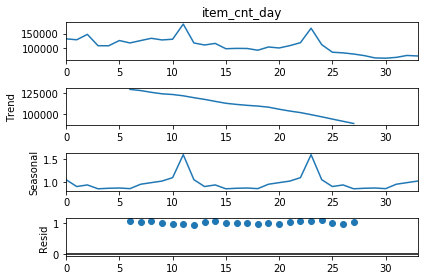

In [13]:
import statsmodels.api as sm
result = sm.tsa.seasonal_decompose(ts,freq=12,model='multiplicative')
plt.figure(figsize=(16,12))
fig = result.plot()

In [39]:
## time series could either be additive or multiplicative
## for more info read this: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

/Users/jassification/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


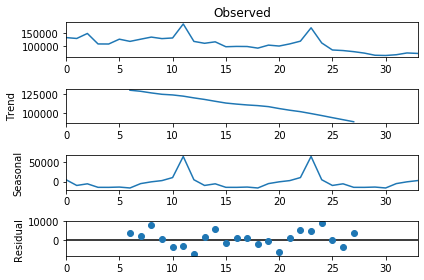

In [14]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

### Stationarity in a TS means that its *mean* does not change with time.
### Stationary TS are easy to model. Hence we first test if a given TS is stationary if not we apply transformations

In [15]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [16]:
# We perform Augmented Dicky Fuller Test which is a pretty common one
#adfResult = adfuller(ts,autolag='AIC')
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


### 1. If the p-value obtained is greater than significance level of 0.05. 
### 2. And the ADF statistic is higher than any of the critical values.
## Then your series is non-stationary

In [20]:
# function to create a differenced series:
def difference(data,interval=1):
    diff = list()
    for i in range(interval,len(data)):
        value = data[i] - data[i-interval]
        diff.append(value)
    return pd.Series(diff)

In [21]:
check = difference(ts)

In [22]:
check.size

33

In [23]:
ts.size

34